# **Preliminary Tasks**

In [62]:
!pip install nltk

## Importing Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Importing Librairies

In [159]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import os
import re
import unicodedata

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, f1_score, auc, confusion_matrix

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## DataPath

In [65]:
DATA_PATH = "/content/drive/My Drive/SPAM_HAM/SMSSpamCollection.txt"

# **Utils**

In [97]:
def getPrecisionRecall(conf_matrix):
  TP = conf_matrix[1][1]
  TN = conf_matrix[0][0]
  FP = conf_matrix[0][1]
  FN = conf_matrix[1][0]

  precision = TP / (TP  + FP)
  recall = TP / (TP + FN)

  return precision, recall

def getF1(precision, recall):
  f1 = 2*precision*recall / (precision + recall)
  return f1

def MakeTable(keys, values):
  dictionary = dict(zip(keys, values))
  tbl_scores = pd.DataFrame(dictionary, index=[0]).transpose()
  tbl_scores.columns = ['score']
  return tbl_scores

def plotPRCurve(y_true, y_proba, model_name = 'model'):
  precision, recall, _ = precision_recall_curve(y_true, y_proba)
  f1, auc = f1_score(y_true, y_pred), sklearn.metrics.auc(recall, precision)
  # summarize scores
  print(f'{model_name}: f1=%.3f auc=%.3f' % (f1, auc))
  # plot the precision-recall curves
  no_skill = len(y_true[y_true==1]) / len(y_true)
  pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  pyplot.plot(recall, precision, marker='.', label=model_name)
  # axis labels
  pyplot.xlabel('Recall')
  pyplot.ylabel('Precision')
  # show the legend
  pyplot.legend()
  # show the plot
  pyplot.show()

def applyThreshold(elem, threshold):
  if elem >= threshold:
    return 1
  return 0

# **Data preprocessing**

## Functions

In [74]:
def clean(text):
  """
  Function that cleans up the data by:
  - Removing stopwords
  - applying the compatibility decomposition, removing non-ascii terms, decoding utf-8 and lowercasing
  - Regex parsing and split
  - Lemmatizing i.e.putting together the inflected forms of a word (changing / changes become change)
  """
  lemmatizer = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  tokens = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
  return ' '.join(tokens)

def to_ngrams(corpus):
  """
  - Making use of the TF-IDF vectorizer: Term Frequency * Inverse Document Frequency
    * min_df = 5 means we want the word / n-grams to appear in at least 5 documents (in this case SMS)
    * max_df = 0.5 means that we will only consider words / n-grams that appear in at least 50% of documents
    * ngram_range = (1,2) means we are looking at uni/bi-grams
  """
  tfidf = TfidfVectorizer(min_df = 5, max_df = 0.5, ngram_range=(1,2))
  features = tfidf.fit_transform(corpus)
  return pd.DataFrame(features.todense(), columns=tfidf.get_feature_names())

def preprocess_corpus(corpus):
  df['cleaned_sms'] = df.apply(lambda row: clean(row["sms"]),axis=1)
  df_ngrams = to_ngrams(df['cleaned_sms'])
  return df_ngrams

## Implementation

In [68]:
df = pd.read_csv(DATA_PATH, sep='\t', header=None)
df.columns = ["output", "sms"]

In [75]:
df_ngrams = preprocess_corpus(df)

In [76]:
ohe_spamHam = {'ham':0, 'spam': 1}
X = df_ngrams
y = df['output'].replace(ohe_spamHam)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
""" 
The data is clearly skewed towards HAM emails meaning that simply 
classifying all the emails as SPAM would lead to seemingly good results.
To deal with this issue we will take a look at F1, Precision and Recall metrics
"""

print(f'Training set shape is: {X_train.shape}')
print(f'proportion of SPAM is: {100*y_train.sum()/len(y_train)} %')

Training set shape is: (4457, 2272)
proportion of SPAM is: 13.417096701817366 %


# **Model**

## N-gram with Multinomial Naive Bayes

Although called "Idiot Bayes" NB is especially appropriate when the dimension of the feature space is high.
The assumption of independence given a class j, in this case, is false. However there is empirical evidence of 
strong performance

The reason why I am using the MNB over any NB model can be found in this paper is mainly that it performs better with 
large sets of data. More information can be found in the following paper:

Andrew McCallum, Kamal Nigam, A Comparison of Event Models for Naive Bayes Text Classification 

Link: http://www.cs.cmu.edu/~knigam/papers/multinomial-aaaiws98.pdf 

In [98]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

In [99]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[966   0]
 [ 22 127]]


In [101]:
precision, recall = getPrecisionRecall(conf_matrix)
f1 = getF1(precision, recall)

keys = ['precision', 'recall', 'f1']
values = [precision, recall, f1]

MakeTable(keys, values)

,score
precision,1.000000
recall,0.852349
f1,0.920290


Multinomial NB: f1=0.920 auc=0.965


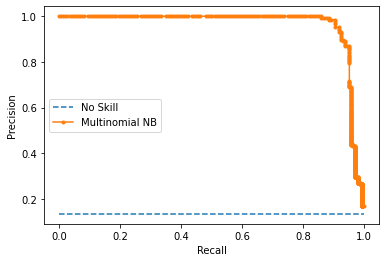

In [102]:
y_proba = mnb.predict_proba(X_test)[:,1]
plotPRCurve(y_test, y_proba, model_name = 'Multinomial NB')

In [116]:
y_pred = np.fromiter((applyThreshold(elem, 0.32) for elem in y_proba), y_proba.dtype)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[965,   1],
       [ 17, 132]])

In [117]:
precision, recall = GetPrecisionRecall(conf_matrix)
f1 = getF1(precision, recall)

keys = ['precision', 'recall', 'f1']
values = [precision, recall, f1]

MakeTable(keys, values)

,score
precision,0.992481
recall,0.885906
f1,0.936170


## Hashing Trick

In this context the Hashing Trick is not very useful as the dataset is fairly small. However, it is important to mention this technique which enable us to have a fixed length of features in our model.

In [140]:
vectorizer = HashingVectorizer(n_features=2**14, alternate_sign=False)
X_hashing = vectorizer.fit_transform(df['cleaned_sms'])
print(X_hashing.shape)

(5572, 16384)


In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_hashing, y, test_size=0.2, random_state=42)

In [144]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
y_proba = mnb.predict_proba(X_test)[:,1]

In [145]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[966,   0],
       [ 65,  84]])

In [146]:
precision, recall = getPrecisionRecall(conf_matrix)
f1 = getF1(precision, recall)

In [147]:
keys = ['precision', 'recall', 'F1']
values = [precision, recall, F1]
MakeTable(keys, values)

,score
precision,1.000000
recall,0.563758
F1,0.920290


MNB_hashingTrick: f1=0.721 auc=0.931


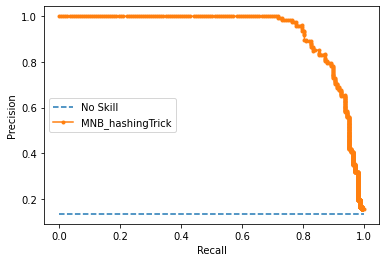

In [149]:
plotPRCurve(y_test, y_proba, 'MNB_hashingTrick')

In [155]:
y_pred = np.fromiter((applyThreshold(elem, 0.28) for elem in y_proba), y_proba.dtype)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[964,   2],
       [ 39, 110]])

In [158]:
precision, recall = getPrecisionRecall(conf_matrix)
f1 = getF1(precision, recall)

keys = ['precision', 'recall', 'f1']
values = [precision, recall, f1]

MakeTable(keys, values)

,score
precision,0.982143
recall,0.738255
f1,0.842912
